# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> CS-109A Introduction to Data Science


## Lab 7: $k$-NN Classification and Imputation

**Harvard University**<br>
**Fall 2019**<br>
**Instructors:** Pavlos Protopapas, Kevin Rader, Chris Tanner<br>
**Lab Instructors:** Chris Tanner and Eleni Kaxiras.  <br>
**Contributors:** Kevin Rader

---

In [1]:
## RUN THIS CELL TO PROPERLY HIGHLIGHT THE EXERCISES
import requests
from IPython.core.display import HTML
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)

## Learning Goals 
In this lab, we'll explore classification models to predict the health status of survey respondents and be able to build a classification decision boundary to predict the resultsing unbalanced classes.

By the end of this lab, you should:
- Be familiar with the `sklearn` implementations of
 - $k$-NN Regression
 - ROC curves and classification metrics
- Be able to optimize some loss function based on misclassification rates
- Be able to impute for missing values
- Be comfortable in the different approaches in handling missingness

In [2]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.api import OLS
import sklearn as sk
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.utils import resample
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
# %matplotlib inline
import seaborn.apionly as sns

C:\Users\kkv09\Anaconda3\envs\cs109a\lib\_collections_abc.py:841: MatplotlibDeprecationWarning: 
The examples.directory rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2. In the future, examples will be found relative to the 'datapath' directory.
  self[key] = other[key]
C:\Users\kkv09\Anaconda3\envs\cs109a\lib\_collections_abc.py:841: MatplotlibDeprecationWarning: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key]
C:\Users\kkv09\Anaconda3\envs\cs109a\lib\_collections_abc.py:841: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2.
  self[key] = other[key]
C:\Users\kkv09\Anaconda3\envs\cs109a\lib\_collections_abc.py:841: MatplotlibDeprecationWarning: 
The verbose.fileo rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key]
C:\Users\kkv09\Anaconda3\envs\cs109a\lib\_collections_abc.py:841: Matplotlib

## Part 1:  General Social Survey Data + EDA

The dataset contains a subset of data from the General Social Survey (GSS) that is a bi-annual survey of roughly 2000 Americans.  We will be using a small subset of the approx 4000 questions they ask.  Specifically we'll use:  

- **id:** respondant's unique ID
- **health:** self-reported health level with 4 categories: poor, fair, good, excellent
- **partyid:** political party affiliation with categories dem, rep, or other
- **age:** age in years
- **sex:** male or female
- **sexornt:** sexual orientation with categories hetero, gay, or bisexual/other
- **educ:** number of years of formal education (capped at 20 years)
- **marital:** marital status with categories married, never married, and no longer married
- **race:** with categories black, white, and other
- **income:** in thousands of dollars

Our goal is to predict whether or not someone is in **poor health** based on the other measures.

For this task, we will exercise our normal data science pipeline -- from EDA to modeling and visualization. In particular, we will show the performance of 2 classifiers:

- Logistic Regression
- $k$-NN Regression

So without further ado...

### EDA

Do the following basic EDA (always good ideas):
1. Determine the dimensions of the data set.
2. Get a glimpse of the data set.
3. Calculate basic summary/descriptive statistics of the variables.

We also ask that you do the following:
4. Create a binary called `poorhealth`.  
5. Explore the distribution of the responses, `health` and `poorhealth`, 
6. Explore what variables may be related to whether or not some is of poor health.  

In [3]:
gssdata = pd.read_csv("data/gsshealth18.csv")

#####
# You code here: EDA
# 1. Determine the dimensions of the data set.
# 2. Get a glimpse of the data set.
####

print("The dimensions of the data set are:", gssdata.shape[0], "observations and", gssdata.shape[1], "variables." )
gssdata.head()


The dimensions of the data set are: 1569 observations and 10 variables.


,id,health,partyid,age,sex,sexornt,educ,marital,race,income
0,1,good,rep,43.0,male,bisexual/other,14.0,never married,white,NaN
1,2,excellent,dem,74.0,female,hetero,10.0,no longer married,white,NaN
2,5,excellent,rep,71.0,male,hetero,18.0,no longer married,black,NaN
3,6,good,dem,67.0,female,bisexual/other,16.0,no longer married,white,NaN
4,7,good,dem,59.0,female,bisexual/other,13.0,no longer married,black,18.75


In [4]:
# 3. Calculate basic summary/descriptive statistics of the variables.
gssdata.describe()


print(gssdata['health'].value_counts())
print(gssdata['partyid'].value_counts())
print(gssdata['sex'].value_counts())
print(gssdata['sexornt'].value_counts())
print(gssdata['marital'].value_counts())
print(gssdata['race'].value_counts())

good         771
excellent    359
fair         355
poor          84
Name: health, dtype: int64
dem      708
rep      514
other    347
Name: partyid, dtype: int64
female    872
male      697
Name: sex, dtype: int64
bisexual/other    907
hetero            640
gay                22
Name: sexornt, dtype: int64
married              655
never married        458
no longer married    454
Name: marital, dtype: int64
white    1137
black     259
other     173
Name: race, dtype: int64


In [5]:
#####
# You code here: EDA
# 4. Create a binary called `poorhealth`.  
# 5. Explore the distribution of the responses, `health` and `poorhealth`, 
# 6. Explore what variables may be related to whether or not some is of poor health.
####

gssdata['poorhealth']=1*(gssdata['health']=='poor')
gssdata['poorhealth'].mean()

0.05353728489483748

**Question**: What classification accuracy could you achieve if you simply predicted `poorhealth` without a model?  What classification accuracy would you get if you were to predict the multi-class `health` variable? Is accuracy the correct metric?

**Solution**: Poor health is a quite rare health status: only 5.35\% of respondents said they were in poor health.  If we predicted all persons to be in better than poo health, our naive classifier would have $1-0.0535 = 0.9465 = 94.65\%$ accuracy.  Acuracy is almost certainly not the ideal metric to use here: we'd be better off looking at false positive and false negative rate instead (it is more important to correctly classify those in poor health than those in better than poor health).

### Data Cleaning - Basic Handling of Missingness

Let's begin by fitting an unregularized logistic regression model to predict poor health based on all the other predictors in the model and three $k$-NN models with $k=5,10,20$.

First we need to do a small amount of data clean-up.  
1. Determine the amount of missingness in each variable.  If there is *a lot*, we will drop the variable from the predictor set (not quite yet).  If there is a little, we will impute.
2. Drop any variables with lots of missingnes (in a new data set).
3. Do simple imputations for variables with a little bit of missingness.
4. Create dummies for categorical predictors.


In [6]:
#########
# 1. Determine the amount of missingness in each variable. 
# Use isna() in combination with .sum()
########

# Your code here

gssdata.isna().sum()

id              0
health          0
partyid         0
age             2
sex             0
sexornt         0
educ            2
marital         2
race            0
income        661
poorhealth      0
dtype: int64

In [7]:
#######
# And then build your predictor set
# 2. Drop any variables with lots of missingnes (in a new data set).
# 3. Do simple imputations for variables with a little bit of missingness.
# 4. Create dummies for categorical predictors.
#########

# get the predictors without a ton of missingness 
# (income was not included since it had so much missingness)
X = gssdata[['partyid','age','sex','sexornt','educ','marital','race']]

#create dummies (lots of ways to do it, two ways will be in the solutions
# create dummies 2 different ways
X['female'] = 1*(gssdata['sex']=="female")
dummies = pd.get_dummies(X[['marital','race','sexornt','partyid']],drop_first=True)

# add the dummies in via the join command.
X = X.join(dummies)

# let's drop the redundat variables no longer needed since we created the dummies
X = X.drop(['partyid','sex','sexornt','marital','race'],axis=1)

# now check the 'nulls'
X.isna().sum()

C:\Users\kkv09\Anaconda3\envs\cs109a\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


age                          2
educ                         2
female                       0
marital_never married        0
marital_no longer married    0
race_other                   0
race_white                   0
sexornt_gay                  0
sexornt_hetero               0
partyid_other                0
partyid_rep                  0
dtype: int64

In [8]:
# handle missingness in age and education
# missingness in marital was handled with get_dummies

# impute the median age
X['age']=X['age'].fillna(X['age'].median())

# impute the most common education: having a HS degree (13 years)
# see histogram for justification
X['educ']=X['educ'].fillna(13)

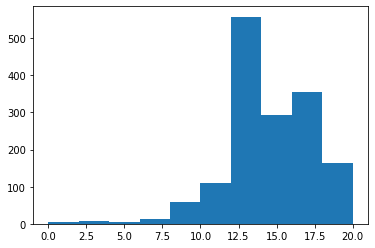

In [9]:
plt.hist(X['educ']);

In [10]:
# we checked these to see if there were any patterns in the missingness.  
# Nothing really showed up.
print(gssdata['age'][pd.isna(gssdata['marital'])])
print(gssdata['age'][pd.isna(gssdata['educ'])])

25      50.0
1478    65.0
Name: age, dtype: float64
529     24.0
1546    75.0
Name: age, dtype: float64


In [11]:
# Just to make sure missingness is gone
X.isna().sum()

age                          0
educ                         0
female                       0
marital_never married        0
marital_no longer married    0
race_other                   0
race_white                   0
sexornt_gay                  0
sexornt_hetero               0
partyid_other                0
partyid_rep                  0
dtype: int64

## Part 2:  Fit Basic Models

In this section we ask you to:

1. Split the data into 70-30 train-test splits (use the code provided...should have been done before EDA :( )
2. Fit an unregularize logistic regression model to predict `poorhealth` from all predictors except income.
    
    2b. If you have time: use 'LogisticRegressionCV' to find a well-tuned L2 regularized model.
    
    
3. Fit $k$-NN classification models with $k=1,15,25$ to predict `poorhealth` from all predictors except income.
4. Report classification accuracy on both train and test set for all models.

In [12]:
#######
# Use the following train_test_split code to: 
# 1. Split the data into 70-30 train-test splits
#######
from sklearn.model_selection import train_test_split
itrain, itest = train_test_split(range(gssdata.shape[0]), train_size=0.70)

# Note: the train-test split above is for the INDICES for splitting in case we 
# want to use them again in the future...we can have an identical split
X_train = X.loc[itrain]
X_test = X.loc[itest]

y_train = gssdata['poorhealth'][itrain]
y_test = gssdata['poorhealth'][itest]

C:\Users\kkv09\Anaconda3\envs\cs109a\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


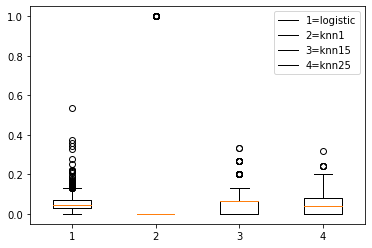

In [13]:
######
# 2. Fit an unregularize logistic regression model to predict `poorhealth` 
#    from all predictors except income.
# 2b. If you have time: use 'LogisticRegressionCV' to find a well-tuned L2 regularized model.
# 3. Fit $k$-NN classification models with k=1,15,25 to predict `poorhealth` 
#    from all predictors except income.
######

from sklearn.neighbors import KNeighborsClassifier

# unregularized Logistic Regression
logit = sk.linear_model.LogisticRegression(C=100000)
logit.fit(X_train,y_train)

# k-NN for k=1, 15, and 25
knn1 = KNeighborsClassifier(1)
knn1.fit(X_train,y_train)

knn15 = KNeighborsClassifier(15)
knn15.fit(X_train,y_train)

knn25 = KNeighborsClassifier(25)
knn25.fit(X_train,y_train)

logit.predict_proba(X_train)[:,1],

#visualize the predictions via boxplots
plt.boxplot([logit.predict_proba(X_train)[:,1],knn1.predict_proba(X_train)[:,1],
             knn15.predict_proba(X_train)[:,1],knn25.predict_proba(X_train)[:,1]])
plt.legend(["1=logistic","2=knn1","3=knn15","4=knn25"]);

In [14]:
######
# 4. Report classification accuracy on both train and test set for all models.
######

print("Classification accuracy for logistic were: \n Train =",
    logit.score(X_train,y_train),", Test =", logit.score(X_test,y_test))
print("Classification accuracy for knn1 were: \n Train =",
    knn1.score(X_train,y_train),", Test =", knn1.score(X_test,y_test))
print("Classification accuracy for knn15 were: \n Train =",
    knn15.score(X_train,y_train),", Test =", knn15.score(X_test,y_test))
print("Classification accuracy for knn25 were: \n Train =",
    knn25.score(X_train,y_train),", Test =", knn25.score(X_test,y_test))

# Note the severe overfitting of knn1, while the others are identical!

Classification accuracy for logistic were: 
 Train = 0.9444444444444444 , Test = 0.9490445859872612
Classification accuracy for knn1 were: 
 Train = 1.0 , Test = 0.8980891719745223
Classification accuracy for knn15 were: 
 Train = 0.9453551912568307 , Test = 0.9490445859872612
Classification accuracy for knn25 were: 
 Train = 0.9453551912568307 , Test = 0.9490445859872612


## Part 3: Evaluate Models via Confusion matrices and ROC Curves

In this part we ask that you:
1. Plot the histograms of predicted probabilities for your favorite model from above
2. Create the confusion matrices for (a) the default threshold for classification and (b) a well-chosen threshold for classification to balance errors more equally.
3. Make ROC curves to evaluate a model's overall useability.
4. Use the ROC curves to select a threshold to balance the two types of errors.

As a reminder of Confustion Matrices:
- the samples that are +ive and the classifier predicts as +ive are called True Positives (TP)
- the samples that are -ive and the classifier predicts (wrongly) as +ive are called False Positives (FP)
- the samples that are -ive and the classifier predicts as -ive are called True Negatives (TN)
- the samples that are +ive and the classifier predicts as -ive are called False Negatives (FN)

A classifier produces a confusion matrix which looks like this:

![confusionmatrix](confusionmatrix_360.png)


IMPORTANT NOTE: In sklearn, to obtain the confusion matrix in the form above, always have the observed `y` first, i.e.: use as `confusion_matrix(y_true, y_pred)`



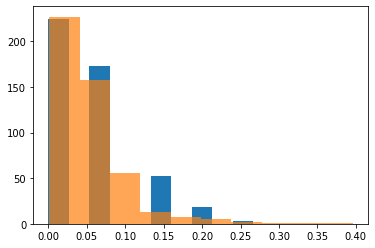

In [15]:
#####
# 1. Plot the histograms of predicted probabilities on test for your favorite 
#    model from above
#####

# We plot them for the logistic and knn15
plt.hist(knn15.predict_proba(X_test)[:,1])
plt.hist(logit.predict_proba(X_test)[:,1],alpha=0.7);

# Note this illustrates the fact that neither model predicted proabilities above 0.5 
# and thus all prediced classification were 0 by default.. It also shows that knn15 
# predictions are in increments of 1/15, while the logistic has predicted probabilties
# in a more 'continuous' like range of values.

In [17]:
#####
#  2. Create the confusion matrices for (a) the default threshold for classification and 
#     (b) a well-chosen threshold for classification to balance errors more equally.
#####

from sklearn.metrics import confusion_matrix

# this function may help to manually make confusion table from a different threshold
def t_repredict(est, t, xtest):
    probs = est.predict_proba(xtest)
    p0 = probs[:,0]
    p1 = probs[:,1]
    ypred = (p1 > t)*1
    return ypred

# Using the logistic model throughout:

# Re-calculating the default confusion matrix
print(confusion_matrix(y_test,t_repredict(knn15,0.5,X_test)))

#And then looking at smaller threshold values: 0.32 and 0.06
print(confusion_matrix(y_test,t_repredict(knn15,0.32,X_test)))
print(confusion_matrix(y_test,t_repredict(knn15,0.06,X_test)))


[[447   0]
 [ 24   0]]
[[447   0]
 [ 24   0]]
[[217 230]
 [  8  16]]


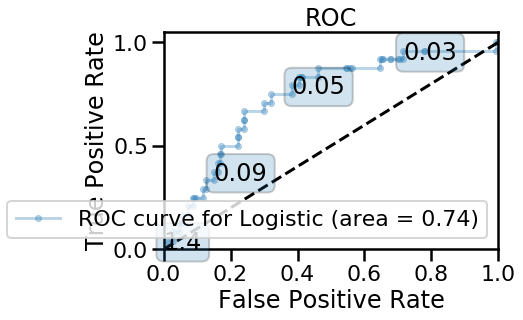

In [18]:
#####
# 3. Make ROC curves to evaluate a model's overall useability.
#####

from sklearn.metrics import roc_curve, auc

# a function to make 'pretty' ROC curves for this model
def make_roc(name, clf, ytest, xtest, ax=None, labe=5, proba=True, skip=0):
    initial=False
    if not ax:
        ax=plt.gca()
        initial=True
    if proba:#for stuff like logistic regression
        fpr, tpr, thresholds=roc_curve(ytest, clf.predict_proba(xtest)[:,1])
    else:#for stuff like SVM
        fpr, tpr, thresholds=roc_curve(ytest, clf.decision_function(xtest))
    roc_auc = auc(fpr, tpr)
    if skip:
        l=fpr.shape[0]
        ax.plot(fpr[0:l:skip], tpr[0:l:skip], '.-', alpha=0.3, label='ROC curve for %s (area = %0.2f)' % (name, roc_auc))
    else:
        ax.plot(fpr, tpr, '.-', alpha=0.3, label='ROC curve for %s (area = %0.2f)' % (name, roc_auc))
    label_kwargs = {}
    label_kwargs['bbox'] = dict(
        boxstyle='round,pad=0.3', alpha=0.2,
    )
    if labe!=None:
        for k in range(0, fpr.shape[0],labe):
            #from https://gist.github.com/podshumok/c1d1c9394335d86255b8
            threshold = str(np.round(thresholds[k], 2))
            ax.annotate(threshold, (fpr[k], tpr[k]), **label_kwargs)
    if initial:
        ax.plot([0, 1], [0, 1], 'k--')
        ax.set_xlim([0.0, 1.0])
        ax.set_ylim([0.0, 1.05])
        ax.set_xlabel('False Positive Rate')
        ax.set_ylabel('True Positive Rate')
        ax.set_title('ROC')
    ax.legend(loc="lower right")
    return ax


sns.set_context("poster")
make_roc("Logistic", logit, y_test, X_test, ax=None, labe=20, proba=True, skip=1);
    

**Question**
4. Use the ROC curves to select a threshold to balance the two types of errors.

**Answer** It looks like based on the logistic model, a threshold of somwhere around 0.04 will give us a very high true positive rate (80\% or so) before taking on "too high" of a false positive rate (just a tad over 50\%).  


## Part 4: Imputation

In this part we ask that you explore the effects of imputation:
1. Plot the histogram of `income`.
2. Create a new variable `income_imp` that imputes the median or mean income for all the missing values and plot the histogram for this new variable.
3. Compare the histograms above.


4. Update your `poorhealth` prediction model(s) by incorporating `income_imp`. 
5. Compare the accuracy of this new model.


And if there is time:
       
6. Create a new variable `income_imp2` that imputes the value via a model.
7. Update your `poorhealth` prediction model(s) by incorporating `income_imp2`. 
8. Compare the accuracy of this newest model.

C:\Users\kkv09\Anaconda3\envs\cs109a\lib\site-packages\numpy\lib\histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\kkv09\Anaconda3\envs\cs109a\lib\site-packages\numpy\lib\histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


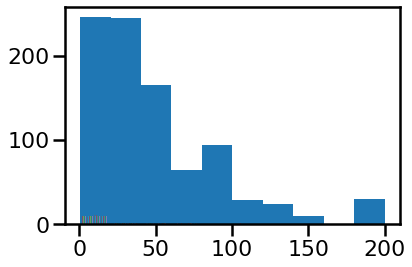

In [19]:
#####
# 1. Plot the histogram of `income`.
# 2. Create a new variable `income_imp` that imputes the median or 
#    mean income for all the missing values and plot the histogram for this new variable.
#####



# First create 'income_imp', and then add it into the predictor set
income_imp = gssdata['income'].fillna(gssdata['income'].median())
X['income_imp'] = income_imp

# plot the original and the version with imputations
plt.hist(gssdata['income'])
plt.hist(X,alpha=0.5);


**Question:**
3. Compare the histograms above.

**Solution:** There is now a spike at the median compared to what was there before.  They distributions are not all that similar in shape or spread (but center is very similar).

In [20]:
#####
# 4. Update your `poorhealth` prediction model(s) by incorporating `income_imp`. 
# 5. Calculate and compare the accuracy of this new model.
#####

# re-use indices for splitting since now we added the imputed 'income' variable
# Note: the response is unaffected so does not need to be redefined.
X_train = X.loc[itrain]
X_test = X.loc[itest]

logit_imp1 = sk.linear_model.LogisticRegression(C=100000)
logit_imp1.fit(X_train,y_train)

knn15_imp1 = KNeighborsClassifier(15)
knn15_imp1.fit(X_train,y_train)

print(confusion_matrix(y_test,t_repredict(logit,0.07,X_test)))
print(confusion_matrix(y_test,t_repredict(logit_imp1,0.07,X_test)))

X_train.head()

C:\Users\kkv09\Anaconda3\envs\cs109a\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


ValueError: X has 12 features per sample; expecting 11

**Question:**
5. Compare the accuracies.

**Answer:** Nothing has improved.  The accuracies are identical for both the logistic and knn models (looking at varios different thresholds.

In [21]:
#####
# And if there is time:
# 6. Create a new variable `income_imp2` that imputes the value via a model.
# 7. Update your `poorhealth` prediction model(s) by incorporating `income_imp2`. 
# 8. Calculate and compare the accuracy of this newest model.
#####

# the y_imp is observed incomes in train for building an imputation model to 
# impute values on training and test, and the X_imp is everything else in train 
# (we could use the true response health or poorhealth, but we decided not to here).

income_train = gssdata['income'][itrain]

# all the missing observations' predictors
miss_index = gssdata['income'][gssdata['income'].isna()].index
X_miss = X.loc[gssdata['income'].isna(),:]
X_miss = X_miss.drop('income_imp',axis=1)

# all the available observed incomes (and predictors) within train to be used to 
# build a model to predict income
y_imp = income_train.dropna()
X_imp = X_train.drop('income_imp',axis=1).loc[itrain]
X_imp = X_imp.loc[income_train.isna()==False,:]

# fit the model
lm = sk.linear_model.LinearRegression()
lm.fit(X_imp,y_imp)

# do the predictions without noise, and turn it into a series for imputation
y_miss = lm.predict(X_miss)
y_miss_series = pd.Series(data = y_miss, index = miss_index)

# create the imputed income variable for all observations
income_imp2 = gssdata['income'].fillna(y_miss_series)

# add income_imp into the train and test sets properly 
X_train['income_imp'] = income_imp2[itrain]
X_test['income_imp'] = income_imp2[itest]

# go back to the primary classifciatoin modeling...
logit_imp2 = sk.linear_model.LogisticRegression(C=100000)
logit_imp2.fit(X_train,y_train)

knn15_imp2 = KNeighborsClassifier(15)
knn15_imp2.fit(X_train,y_train)

# quick peak at predictions to see if anything has changed 
print(confusion_matrix(y_test,t_repredict(logit,0.07,X_test)))
print(confusion_matrix(y_test,t_repredict(logit_imp2,0.07,X_test)))



C:\Users\kkv09\Anaconda3\envs\cs109a\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


ValueError: X has 12 features per sample; expecting 11

In [22]:
X_imp.head()

,age,educ,female,marital_never married,marital_no longer married,race_other,race_white,sexornt_gay,sexornt_hetero,partyid_other,partyid_rep
263,70.0,12.0,0,0,1,0,1,0,0,0,0
186,59.0,17.0,0,0,1,0,1,0,1,0,1
827,32.0,12.0,1,0,0,1,0,0,0,0,0
1376,36.0,12.0,0,1,0,0,1,0,1,0,0
919,68.0,14.0,1,0,0,0,1,0,1,0,1


In [ ]:
######
# Now to do imputation with uncertainty:
# we can use the same imputation model from the previous part 
######

# first add the standard y-hats just like before
y_miss = lm.predict(X_miss)

# we need to estimate the residual variance (MSE), sigma2_hat, from the observed incomes 
# that were used to train the model
y_hat = lm.predict(X_imp)
sigma2_hat = sk.metrics.mean_squared_error(y_imp,y_hat)

# sample a residual from the assumed normal distribution
e_miss = np.random.normal(loc=0,scale=np.sqrt(sigma2_hat),size=y_miss.shape[0])

# create the income measurement with uncertainty to be imputed
y_miss_series = pd.Series(data = y_miss+e_miss, index = miss_index)

# imputed them properly into where they belong.
income_imp3 = gssdata['income'].fillna(y_miss_series)

# add income_imp into the train and test sets properly 
X_train['income_imp'] = income_imp3[itrain]
X_test['income_imp'] = income_imp3[itest]

# go back to the primary classifciatoin modeling...
logit_imp3 = sk.linear_model.LogisticRegression(C=100000)
logit_imp3.fit(X_train,y_train)

knn15_imp3 = KNeighborsClassifier(15)
knn15_imp3.fit(X_train,y_train)

print(confusion_matrix(y_test,t_repredict(logit,0.07,X_test)))
print(confusion_matrix(y_test,t_repredict(logit_imp3,0.07,X_test)))


In [ ]:
# Let's use AUC for evaluations 

fpr, tpr, thresholds=roc_curve(y_test, logit.predict_proba(X_test)[:,1])
print("AUC for logistic model when income was dropped: \n",
      auc(fpr, tpr))

fpr, tpr, thresholds=roc_curve(y_test, logit_imp1.predict_proba(X_test)[:,1])
print("AUC for logistic model when imputations were done with median imputation: \n",
      auc(fpr, tpr))

fpr, tpr, thresholds=roc_curve(y_test, logit_imp2.predict_proba(X_test)[:,1])
print("AUC for logistic model when imputation were done via linear regression: \n",
      auc(fpr, tpr))
fpr, tpr, thresholds=roc_curve(y_test, logit_imp3.predict_proba(X_test)[:,1])
print("AUC for logistic model when imputation were done via linear regression with uncertainty: \n",
      auc(fpr, tpr))

**Question:**
8. Compare the accuracies.

**Answer:** Things have improved!  Using the uncertainty in the imputations has slightly improved the AUC for the classification model.  But this is ONLY slightly!